In [56]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Kinetic Ising Model simulation
Ising model with $N$ spins $\{-1,1\}$, cuplings matrix $J_{ij}$ and external field $h_i$. 

At each time step $\delta t$ each spin $s_i$ flips with a probability 
$$p_{flip} = \gamma \delta t \frac 1 2 [1-s_i(t)\tanh H_i(t)] \quad with \quad
H_i = h_i + \sum_j J_{ij}s_j(t)$$

In [68]:
class kinetic_ising:
    def __init__(self, N, J, h, gamma = 1):
        self.N = N
        self.J = J
        self.h = h
        self.S = np.ones(N)
        self.H_i = np.dot(self.J,self.S)+self.h
        self.gamma = gamma
        self.history = np.copy(self.S)
        
    def comp_H(self):
        self.H_i = np.dot(self.J,self.S)+self.h
    
    def store(self):
        self.history = np.vstack((self.history,self.S))
    
    def update(self,dt):
        p = np.random.rand(N)
        p_up = dt*self.gamma*0.5*(1-self.S*np.tanh(self.H_i))
        self.S[p < p_up] *= -1
        self.store()
        self.comp_H()
        
    def reset(self):
        self.S = np.ones(N)
        self.history = np.copy(self.S)
    
    #if we put this func outside we can also use njit     
    def C(self,dt):
        # NB : in our case history[i,j] i is the time and j is the spin
        C = np.zeros((N,N))
        # since C is simmetric we can optimize it ... 
        for i in tqdm(range(N),desc='Computing C'):
            for j in range(N):
                C[i,j] = np.mean(self.history[:,i]*self.history[:,j])
        
        C_dot = np.zeros((N,N))
        for i in tqdm(range(N),desc='Computing C_dot'):
            for j in range(N):
                C_dot[i,j] = np.mean(self.history[1:,i]*self.history[:-1,j])
        
        C_dot -= C
        C_dot /= dt
        
        return C,C_dot
    
        
        

In [65]:
np.random.seed(123)
#number of spins
N = 50

#interactions matrix
mu = 0
sigma = 1
J = np.random.normal(mu,sigma,(N,N))

#external field
mu = -0.2
sigma = 0.1
h = np.random.normal(mu,sigma,N)

ising = kinetic_ising(N,J,h)

In [66]:
ising.reset()
np.random.seed(123)

time = 1
steps = 100
dt = time / steps
for i in range(steps):
    ising.update(dt)


In [67]:
ising.C(dt)

Computing C_dot: 100%|██████████| 50/50 [00:00<00:00, 969.24it/s]


(array([[ 1.        ,  1.        ,  0.72277228, ...,  1.        ,
         -0.6039604 ,  0.72277228],
        [ 1.        ,  1.        ,  0.72277228, ...,  1.        ,
         -0.6039604 ,  0.72277228],
        [ 0.72277228,  0.72277228,  1.        , ...,  0.72277228,
         -0.32673267,  1.        ],
        ...,
        [ 1.        ,  1.        ,  0.72277228, ...,  1.        ,
         -0.6039604 ,  0.72277228],
        [-0.6039604 , -0.6039604 , -0.32673267, ..., -0.6039604 ,
          1.        , -0.32673267],
        [ 0.72277228,  0.72277228,  1.        , ...,  0.72277228,
         -0.32673267,  1.        ]]),
 array([[ 0.        ,  0.        ,  1.72277228, ...,  0.        ,
          0.3960396 ,  1.72277228],
        [ 0.        ,  0.        ,  1.72277228, ...,  0.        ,
          0.3960396 ,  1.72277228],
        [-0.27722772, -0.27722772, -2.        , ..., -0.27722772,
          0.67326733, -2.        ],
        ...,
        [ 0.        ,  0.        ,  1.72277228, ...,  

Text(0.5, 1.0, 'Spin evlolution in time. [$s_i=1$ yellow, $s_i=-1$ blue]')

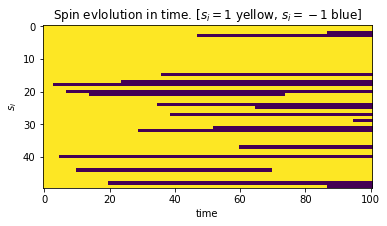

In [8]:
plt.figure(figsize=(10,3))
plt.imshow(ising.history.T)
plt.xlabel('time')
plt.ylabel(r'$s_i$')
plt.title(r'Spin evlolution in time. [$s_i=1$ yellow, $s_i=-1$ blue]')

## Test on function maximization

In [22]:
from scipy.optimize import minimize
def f(x):return (x[0]**2+x[1]**2)

In [24]:
minimize(f,[1,90]).x

array([ 3.18028549e-07, -4.01771698e-06])

## Inference

In [28]:
def L(p,s,C,C_dot,gamma):
    # p are the params, s is the spins history
    N = len(s[0])
    J = p[:N*N].reshape((N,N))
    h = p[N*N:]
    

In [34]:
A = np.ones((2,3))
A

array([[1., 1., 1.],
       [1., 1., 1.]])

In [39]:
np.sum(A[0,:])

3.0